# DSCI 525 - Web and Cloud Computing

***Milestone 4:*** In this milestone, you will deploy the machine learning model you trained in milestone 3.

You might want to go over [this sample project](https://github.ubc.ca/mds-2021-22/DSCI_525_web-cloud-comp_students/blob/master/release/milestone4/sampleproject.ipynb) and get it done before starting this milestone.

Milestone 4 checklist :

- [X] Use an EC2 instance.
- [X] Develop your API here in this notebook.
- [X] Copy it to ```app.py``` file in EC2 instance.
- [X] Run your API for other consumers and test among your colleagues.
- [X] Summarize your journey.

In this milestone, you will do certain things that you learned. For example...
- Login to the instance
- Work with Linux and use some basic commands
- Configure security groups so that it accepts your webserver requests from your laptop
- Configure AWS CLI

In some places, I explicitly mentioned these to remind you.

In [1]:
## Import all the packages that you need
# from flask import Flask, request, jsonify
# import joblib
# import numpy as np
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

## 1. Develop your API

rubric={mechanics:45}

You probably got how to set up primary URL endpoints from the [sampleproject.ipynb](https://github.ubc.ca/mds-2021-22/DSCI_525_web-cloud-comp_students/blob/master/release/milestone4/sampleproject.ipynb) and have them process and return some data. Here we are going to create a new endpoint that accepts a POST request of the features required to run the machine learning model that you trained and saved in last milestone (i.e., a user will post the predictions of the 25 climate model rainfall predictions, i.e., features,  needed to predict with your machine learning model). Your code should then process this data, use your model to make a prediction, and return that prediction to the user. To get you started with all this, I've given you a template that you should fill out to set up this functionality:

***NOTE:*** You won't be able to test the flask module (or the API you make here) unless you go through steps in ```2. Deploy your API```. However, you can make sure that you develop all your functions and inputs properly here.

```python
from flask import Flask, request, jsonify
import joblib
import numpy as np
## Import any other packages that are needed

app = Flask(__name__)

# 1. Load your model here
model = joblib.load(...)

# 2. Define a prediction function
def return_prediction(...):

    # format input_data here so that you can pass it to model.predict()

    return model.predict(...)

# 3. Set up home page using basic html
@app.route("/")
def index():
    # feel free to customize this if you like
    return """
    <h1>Welcome to our rain prediction service</h1>
    To use this service, make a JSON post request to the /predict url with 25 climate model outputs.
    """

# 4. define a new route which will accept POST requests and return model predictions
@app.route('/predict', methods=['POST'])
def rainfall_prediction():
    content = request.json  # this extracts the JSON content we sent
    prediction = return_prediction(...)
    results = {...}  # return whatever data you wish, it can be just the prediction
                     # or it can be the prediction plus the input data, it's up to you
    return jsonify(results)
```

**Solution for Task 1:**

```python
from flask import Flask, request, jsonify
import joblib
import numpy as np

app = Flask(__name__)

# 1. Load your model here
model = joblib.load("model.joblib")
# 2. Define a prediction function
def return_prediction(input_data):
    # format input_data here so that you can pass it to model.predict()
    data = input_data["data"]
    pred = np.array(data).reshape(1, 25)
    return model.predict(pred)


# 3. Set up home page using basic html
@app.route("/")
def index():
    # feel free to customize this if you like
    return """
    <h1>Welcome to our rain prediction service</h1>
    To use this service, make a JSON post request to the /predict url with 5 climate model outputs.
    """


# 4. define a new route which will accept POST requests and return model predictions
@app.route("/predict", methods=["POST"])
def rainfall_prediction():
    content = request.json  # this extracts the JSON content we sent
    prediction = return_prediction(content)
    results = {
        "Prediction": prediction.tolist()
    }  # return whatever data you wish, it can be just the prediction
    # or it can be the prediction plus the input data, it's up to you
    return jsonify(results)
```

## 2. Deploy your API

rubric={mechanics:40}

Once your API (app.py) is working, we're ready to deploy it! For this, do the following:

1. Setup an EC2 instance. Make sure you add a rule in security groups to accept `All TCP` connections from `Anywhere`. SSH into your EC2 instance from milestone2.
2. Make a file `app.py` file in your instance and copy what you developed above in there. 

    2.1 You can use the Linux editor using ```vi```. More details on vi Editor [here](https://www.guru99.com/the-vi-editor.html). Use your previous learnings, notes, mini videos, etc. You can copy code from your jupyter and paste it into `app.py`.
    
    2.2 Or else you can make a file in your laptop called app.py and copy it over to your EC2 instance using ```scp```. Eg: ```scp -r -i "ggeorgeAD.pem" ~/Desktop/app.py  ubuntu@ec2-xxx.ca-central-1.compute.amazonaws.com:~/```

3. Download your model from s3 to your EC2 instance. You want to configure your S3 for this. Use your previous learnings, notes, mini videos, etc.
4. You should use one of those package managers to install the dependencies of your API, like `flask`, `joblib`, `sklearn`, etc...

    4.1. (Additional help) you can install the required packages inside your terminal.
        - Install conda:
            wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
            bash Miniconda3-latest-Linux-x86_64.sh
        - Install packages (there might be others): 
            conda install flask scikit-learn joblib

5. Now you're ready to start your service, go ahead and run `flask run --host=0.0.0.0 --port=8080`. This will make your service available at your EC2 instance's `Public IPv4 address` on port 8080. Please ensure that you run this from where ```app.py``` and ```model.joblib``` reside.
6. You can now access your service by typing your EC2 instances `public IPv4 address` append with `:8080` into a browser, so something like `http://Public IPv4 address:8080`. From step 4, you might notice that flask output saying "Running on http://XXXX:8080/ (Press CTRL+C to quit)", where XXXX is `Private IPv4 address`, and you want to replace it with the `Public IPv4 address`
7. You should use `curl` to send a post request to your service to make sure it's working as expected.
>EG: curl -X POST http://your_EC2_ip:8080/predict -d '{"data":[1,2,3,4,53,11,22,37,41,53,11,24,31,44,53,11,22,35,42,53,12,23,31,42,53]}' -H "Content-Type: application/json"

8. Now, what happens if you exit your connection with the EC2 instance? Can you still reach your service?
9. We could use several options to help us persist our server even after we exit our shell session. We'll be using `screen`. `screen` will allow us to create a separate session within which we can run `flask` and won't shut down when we exit the main shell session. Read [this](https://linuxize.com/post/how-to-use-linux-screen/) to learn more on ```screen```.
10. Now, create a new `screen` session (think of this as a new, separate shell), using: `screen -S myapi`. If you want to list already created sessions do ```screen -list```. If you want to get into an existing ```screen -x myapi```.
11. Within that session, start up your flask app. You can then exit the session by pressing `Ctrl + A then press D`. Here you are detaching the session, once you log back into EC2 instance you can attach it using ```screen -x myapi```.
12. Feel free to exit your connection with the EC2 instance now and try reaccessing your service with `curl`. You should find that the service has now persisted!
13. ***CONGRATULATIONS!!!*** You have successfully got to the end of our milestones. Move to Task 3 and submit it.

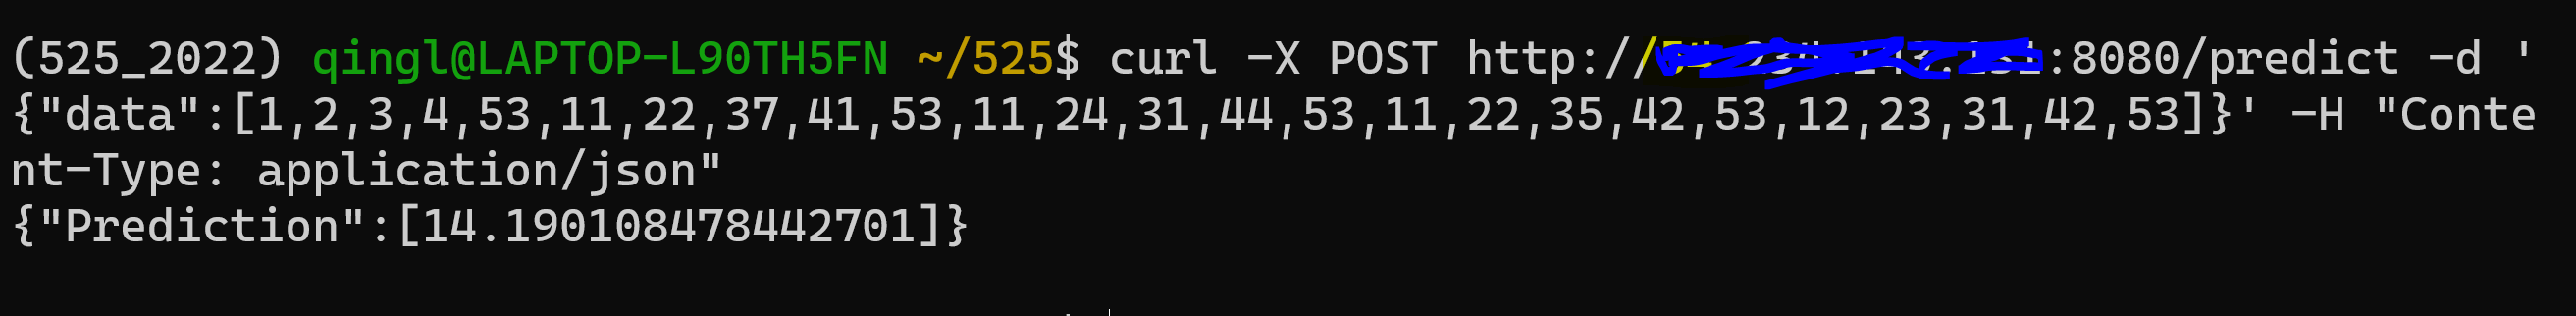

## 3. Summarize your journey from Milestone 1 to Milestone 4
rubric={mechanics:10}
>There is no format or structure on how you write this. (also, no minimum number of words).  It's your choice on how well you describe it.

**Solution for Task 3:**

> **Milestone 1**: in this milestone we realized how difficult it was to work with large datasets on our local machine and for each local machine depending on its RAM storage the data computation speed can be varied. Our team also explored using alternatives such as changing `dtype` of the data, and loading just the columns we were interested to speed up the process; however, the time consumption and computer machine capabilities still are primary challenges to process the massive amount of data. It also becomes clear throughout this milestone that with large data a simple c.s.v. file or any other traditional data wrangling methods are ineffective. Additionally, we found that the Parquet file can make working with big data much easier and vastly improve the processing time. To sum up, this milestone gave us insight for demanding web and cloud computing services when working with big data.
>
>**Milestone 2**: in this milestone we established the cloud infrastructure for purpose of completing the large data processing, including setting up an E2C instance that's capable of handling all the wrangling and saving machine learning file in the S3 bucket. Built upon the Amazon Web Services (AWS) platform, the parquet data which had been downloaded to the EC2 instance was moved to the S3 bucket along with the `observed_daily_rainfall_SYD.csv` file generated in Milestone 1 on a local computer.
>
>**Milestone 3**: in this milestone we set up EMR cluster with Spark and JupyterHub for purpose of developing a machine learning model to predict rainfall in Australia using a large dataset. We also found the best hyperparameter for our ensemble model using Spark's `MLlib`, and our best model was saved to a `.joblib` file.
>
>**Milestone 4**: for this last milestone we deployed the machine learning model we trained from the previous milestone as a REST-API, and so other people can assess or utilize it. Specifically, we used Flask as a simple web framework to build a web service that receives features needed to run the machine learning model, and then sends the prediction back to the user. In the end, we successfully deployed our machine learning model in the cloud for others to make prediction for it. 

## 4. Submission instructions
rubric={mechanics:5}

In the textbox provided on Canvas please put a link where TAs can find the following-
- [X] This notebook with solution to ```1 & 3```
- [X] Screenshot from 
    - [X] Output after trying curl. Here is a [sample](https://github.ubc.ca/mds-2021-22/DSCI_525_web-cloud-comp_students/blob/master/release/milestone4/images/curl_deploy_sample.png). This is just an example; your input/output doesn't have to look like this, you can design the way you like. But at a minimum, it should show your prediction value.